In [0]:
import torch
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader 
from torch import nn
from torch.optim import Adam
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Sampler
from sklearn.preprocessing import scale

In [0]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
device = get_default_device()

In [0]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)
    

In [0]:
class StockDataset(Dataset):
    def __init__(self,dir_path,start_year = 2002,end_year = 2017,window_size = 12):
        self.dir_path = dir_path
        self.start_year = start_year
        self.end_year = end_year
        self.window_size = window_size
        self.data = self._load_data(self.dir_path,self.start_year,self.end_year)
#         self.preprocessed_data = self._preprocess(self.data)
        self.x,self.y = self._create_features_and_labels(self.data,self.window_size)
        
        
        
        
        
        
    def _load_data(self,dir_path,start_year,end_year):
        col_name = ["date","time","open","high","low","close","volume"]
        df_full = pd.DataFrame(columns = col_name)
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                year = int(file.split(".")[0].split("_")[-1])
                if (file.endswith(".csv") and year >= start_year 
                and year <= end_year):
                    df = pd.read_csv(os.path.join(root,file),names = col_name)
                    df_full = pd.concat([df_full,df])
                    print("Stock data of year {0} loaded".format(str(year)))
        df_full.reset_index(inplace = True)
        return df_full
      
      
      
    
    
    def _create_features_and_labels(self,df,window_size):
       
        n = df.shape[0]
        x_array = np.empty(shape = (n - window_size,window_size))
        y_array = np.empty(shape = (n - window_size,1))
        close_index = df.close
        for i in tqdm(range(n-window_size),desc =  "Creating Features and Labels..."):
            x_array[i] = close_index.iloc[i:i+window_size].values
            y_array[i] = close_index.iloc[i + window_size]
        x_array = scale(x_array)
        y_array = scale(y_array)
        return x_array,y_array
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.x.shape[0]

In [26]:
PATH = "/content/drive/My Drive/stock_data/EURGBP"
data = StockDataset(dir_path=PATH,start_year=2017,window_size=30)

Creating Features and Labels...:   0%|          | 704/370223 [00:00<00:52, 7033.55it/s]

Stock data of year 2017 loaded


Creating Features and Labels...: 100%|██████████| 370223/370223 [00:32<00:00, 11221.92it/s]


In [0]:
class TestSampler(Sampler):
    r"""Samples elements sequentially, always in the same order.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source):
        self.data_source = data_source

    def __iter__(self):
        return iter(range(self.data_source[0],self.data_source[-1] + 1))

    def __len__(self):
        return len(self.data_source)

In [0]:
train_split = .8
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SequentialSampler(train_indices)
test_sampler = TestSampler(test_indices)

In [0]:
train_dl = DataLoader(data,batch_size=64,sampler=train_sampler,num_workers=8)
test_dl = DataLoader(data,batch_size=64,sampler=test_sampler,num_workers=8)

In [30]:
for xb,yb in test_dl:
  print(xb.device)
  break

cpu


In [0]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch,self.device)
    def __len__(self):
        return len(self.dl)

In [0]:
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

In [0]:
for xb,yb in test_dl:
  print(xb.device)
  break

cuda:0


In [0]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim,batch_first = True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.Sigmoid()
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        x = x[...,None].float()
        # 12 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 12,
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:,-1, :]) 
        # out.size() --> 100, 10
        return self.relu(out)

In [0]:
model = LSTMModel(input_dim = 1 , hidden_dim = 8, layer_dim = 1, output_dim = 1)

In [33]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 1])
torch.Size([32, 8])
torch.Size([32])
torch.Size([32])
torch.Size([1, 8])
torch.Size([1])


In [0]:
def Train(train_dl,model,opt,loss_fn):
  losses =[]
  nums = []
  model.train()
  for xb,yb in train_dl:
    preds = model(xb)
    loss = loss_fn(preds,yb.float())
  
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())
    nums.append(len(xb))
      
      
  total = np.sum(nums)
  avg_loss = np.sum(np.multiply(losses,nums)) / total
  
  return avg_loss

In [0]:
def Validation(test_dl,model,loss_fn):
  model.eval()
  with torch.no_grad():
    losses = []
    nums = []
    for xb,yb in test_dl:
      preds = model(xb)
      loss = loss_fn(preds,yb.float())
      losses.append(loss.item())
      nums.append(len(xb))
    total = np.sum(nums)
    avg_loss = np.sum(np.multiply(losses,nums)) / total
    return avg_loss

In [0]:
def fit(epoch,train_dl,test_dl,model,opt,loss_fn):
  
  
  total_loss_train = []
  total_loss_test = []
  opt
  
  
  for i in range(epoch):
    
    #training Phase
    train_loss = Train(train_dl,model,opt,loss_fn)
    total_loss_train.append(train_loss)
    
    #test phase
    val_loss = Validation(test_dl,model,loss_fn)
    total_loss_test.append(val_loss)
    print("Epoch [{}/{}], train_loss: {:.4f}, test_loss: {:.4f}".format(i+1,epoch,
                                                                       train_loss,
                                                                       val_loss))
  return total_loss_train,total_loss_test
    

In [46]:
optimizer = Adam(model.parameters(),lr = 0.001)
loss_fn = nn.MSELoss()
loss_train,loss_test = fit(30,train_dl,test_dl,model,optimizer,loss_fn)

Epoch [1/30], train_loss: 0.7689, test_loss: 0.0036
Epoch [2/30], train_loss: 0.7142, test_loss: 0.0036
Epoch [3/30], train_loss: 0.7136, test_loss: 0.0026
Epoch [4/30], train_loss: 0.7135, test_loss: 0.0023
Epoch [5/30], train_loss: 0.7134, test_loss: 0.0022
Epoch [6/30], train_loss: 0.7134, test_loss: 0.0019
Epoch [7/30], train_loss: 0.7137, test_loss: 0.0018


KeyboardInterrupt: ignored

In [0]:
y_pred = np.empty(shape = (1,1))
y_act = np.empty(shape = (1,1))
for xb,yb in test_dl:
  with torch.no_grad():
    y_pred = np.concatenate([y_pred,model(xb).numpy()],axis = 0)
    y_act = np.concatenate([y_act,yb.numpy()],axis = 0)

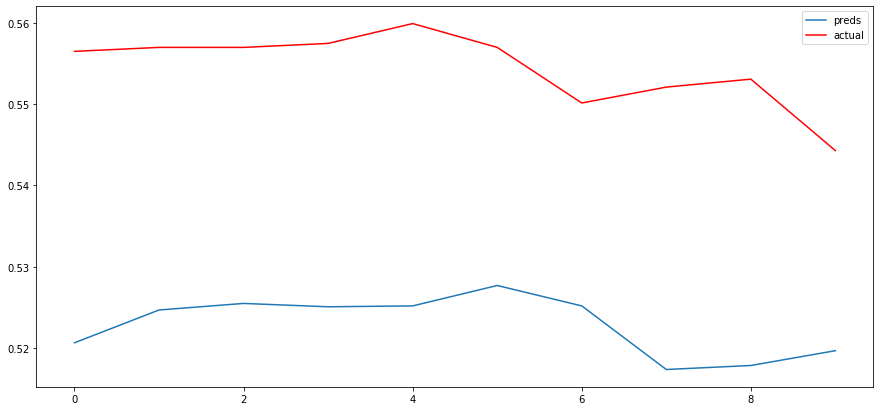

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7), nrows=1, ncols=1 ) # create figure & 1 axis
ax.plot(y_pred[-1000:-990],label = "preds")
ax.plot(y_act[-1000:-990],color = "red",label = "actual")
ax.legend(loc = "upper right")
# fig.savefig('/content/drive/My Drive/stock_data/prediction.png')   # save the figure to file
# plt.close(fig)
# plt.figure(1)
# plt.plot(y_pred[-2000:])
# plt.plot(y_act[-2000:],color = "red")